In [1]:
import torch 
from torch import nn
from torch.nn import functional as F
from Ford_dataset import SatGrdDatasetFord, train_logs, train_logs_img_inds, test_logs, test_logs_img_inds
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import models 


class Config():
    device = 'cuda'
    cameras = ['FL']

    orig_satmap_A = 512
    sat_map_A = 64
    meter_per_pixel = 0.22 # this is fixed for the ford dataset meter per pixel of the original shape satellite map 512 * 512 

    vol_car_xyz = torch.tensor([64, 64, 6], dtype=torch.int64)   #volume around car xyz shape  
    orig_img_H = 448 #original image height that is going as input into the neural network 
    orig_img_W = 896
    img_H = 448//8 #the output shape of the image encoder, later to be lifted to 3D 
    img_W = 896//8
    batch_size = 8

config = Config()

logs_start = 0; logs_end = 5
range_lat = 20; range_lot=20; rotation_range =20; #meters, meters, degress

train_set  = SatGrdDatasetFord(logs=train_logs[logs_start:logs_end], logs_img_inds=train_logs_img_inds[logs_start:logs_end], H=config.orig_img_H, W=config.orig_img_W, cameras=config.cameras, mode='train')
val_set    = SatGrdDatasetFord(logs=test_logs[logs_start:logs_end],  logs_img_inds=test_logs_img_inds[logs_start:logs_end],  H=config.orig_img_H, W=config.orig_img_W, cameras=config.cameras, mode='val')

train_loader = DataLoader(train_set, batch_size=config.batch_size, shuffle=True, num_workers=1, prefetch_factor=2)
val_loader = DataLoader(val_set, batch_size=config.batch_size, shuffle=False, num_workers=1, prefetch_factor=2)
Rs = {key:item.to(config.device) for key, item in train_set.Rs.items()}
Ts = {key:item.to(config.device) for key, item in train_set.Ts.items()}
Ks = {key:item.to(config.device) for key, item in train_set.Ks.items()}
config.Rs = Rs; config.Ts = Ts; config.Ks = Ks

print(len(train_loader), len(val_loader))



7937 3585


In [2]:
from models import ForwardBlock, DownBlock, UpBlock, UnetFlow

# the same encoder is used for both satelite and ground images as long as they 2 networks with different weights 
class ImageEncoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        self.img_8 = nn.Sequential(*list(self.resnet50.children())[:-4])
        self.img_16 = list(self.resnet50.children())[-4]
        self.img_32 = list(self.resnet50.children())[-3]
        self.up_16 = UpBlock(2048+1024, 1024)
        self.up_8 = UpBlock(1024+512, 512)

    def forward(self, input):
        out_8 = self.img_8(input)
        out_16 = self.img_16(out_8)
        out_32 = self.img_32(out_16)

        out_up_16 = self.up_16(out_32, out_16)
        out_up_8  = self.up_8(out_up_16, out_8)

        return out_up_8

class BEVEncoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.down_1 = ForwardBlock(512*6, 512)
        self.down_2 = DownBlock(512, 1024)
        self.down_4 = DownBlock(1024, 1024)
        
        self.up_2 = UpBlock(1024+1024, 1024)
        self.up_1 = UpBlock(1024+512, 512)

    def forward(self, input):
        B,C,X,Y,Z = input.shape
        # space to channel 
        input = input.permute([0,1,4,2,3]).contiguous()# input:B,C,Z,X,Y
        input = input.view(B,C*Z,X,Y)

        down_1 = self.down_1(input)#512,64,64
        down_2 = self.down_2(down_1)#1024, 32, 32
        down_4 = self.down_4(down_2)#1024, 16, 16

        up_2 = self.up_2(down_4, down_2)#1024, 32, 32
        up_1 = self.up_1(up_2, down_1)#512, 64, 64

        return up_1

class LiftingModule(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        self.config = config

    def get_xyz_car(self):
        '''
        space around the ego vehicle:
        in voxels shape (x,y,z), default (128,128,4)
        space around the ego vehicle:
        in meters 
        x axis is looking front [-56.3, 56.3] 
        y axis is looking left  [-56.3, 56.3]
        z axis is looking down  [-4.6, 1.4]

        the axis of the vehicle is ?

        returns:
        xyz of shape(x,y,z, 3) where 3 represents the xyz position  
        xyz_id of shape(x,y,z, 3) where 3 is the index x,y,z of that cell 
        '''

        x = (torch.arange(self.config.vol_car_xyz[0], dtype=torch.float32) / (self.config.vol_car_xyz[0] -1)) - 0.5
        x = - x * self.config.orig_satmap_A * self.config.meter_per_pixel
        x = x.unsqueeze(1)
        x = x.repeat(1, self.config.vol_car_xyz[0])

        y = (torch.arange(self.config.vol_car_xyz[1], dtype=torch.float32) / (self.config.vol_car_xyz[1] -1)) - 0.5
        y = y * self.config.orig_satmap_A * self.config.meter_per_pixel
        y = y.unsqueeze(0)
        y = y.repeat(self.config.vol_car_xyz[1], 1)

        xyz = torch.stack((x,y, torch.zeros_like(y)), dim=2).unsqueeze(2)
        xyz = xyz.repeat(1, 1, self.config.vol_car_xyz[2], 1)

        offset = 1.4 #for -0.3 we are at the level of the front camera, for 1.4 we are at the ground level 
        z = offset + ((torch.arange(self.config.vol_car_xyz[2], dtype=torch.float32) / (self.config.vol_car_xyz[2] -1)) -1) * 6

        xyz[:,:,:,2] = z[:] 

        # xyz indices
        x_id = torch.arange(self.config.vol_car_xyz[0], dtype=torch.int64).unsqueeze(1)
        x_id = x_id.repeat(1, self.config.vol_car_xyz[0]) 

        y_id = torch.arange(self.config.vol_car_xyz[1], dtype=torch.int64).unsqueeze(0)
        y_id = y_id.repeat(self.config.vol_car_xyz[1], 1)

        xy_id = torch.stack((x_id, y_id, torch.zeros_like(y_id)), dim =2).unsqueeze(2)
        
        xyz_id = xy_id.repeat(1,1,self.config.vol_car_xyz[2],1)
        xyz_id[:,:,:, 2] = torch.arange(self.config.vol_car_xyz[2], dtype=torch.int64)


        return xyz.contiguous(), xyz_id.contiguous()

    
    def render_xyz(self, R, T, K, xyz, xyz_ids):
        '''
        uvs shape [2, n] to calculate gather_ids used for image of shape [C,H,W]
        scatter_ids shape [3, n] used for volume of shape [C,H,W,Z]  
        '''
        K = K.clone()
        K[0] = K[0] * (self.config.img_W / self.config.orig_img_W)
        K[1] = K[1] * (self.config.img_H / self.config.orig_img_H)

        # R, T is from camera to body 
        # xyz relative to the car body, xyz_cam is relative to camera
        xyz_cam = (R.T @ xyz.view(-1,3).T - T.unsqueeze(1))
        uvs = K @ xyz_cam
        uvs[0] = uvs[0]/ uvs[2]
        uvs[1] = uvs[1]/ uvs[2]

        bf = (uvs[0, :] >= 0) & (uvs[1, :] >= 0) & (uvs[0, :] < self.config.img_W-1) & (uvs[1, :]<self.config.img_H-1) & (uvs[2, :] > 0.1)

        # uvs = torch.round(uvs[:, bf]).type(torch.int64)
        uvs = uvs[:, bf]

        xyz_ids_filtered = xyz_ids.view(-1, 3).T[:, bf]
        scatter_ids = xyz_ids_filtered

        #v = x height u = y width in a matrix (v,u), uvs[0] -> u,y, uvs[1] -> v,x, ids = y + x * y_size
        # gather_ids = uvs[0] + self.config.img_W * uvs[1]
        # # ids = z + y * z_size + x * y_size * z_size
        # scatter_ids = xyz_ids_filtered[2] + xyz_ids_filtered[1] * self.config.vol_car_xyz[2] + xyz_ids_filtered[0] * self.config.vol_car_xyz[1] * self.config.vol_car_xyz[2]

        return uvs[:2], scatter_ids
    
    def lift_features(self, img, volume, uvs, scatter_ids):
        '''
        Lifting features using bilinear interpolation 
        
        img shape (3, H, W)
        volume shape (3, X, Y, Z)
        uvs shape (2,n)
        scatter_ids shape (3,n)
        '''
        gather_ids = torch.zeros_like(uvs)
        gather_ids[0, :] = uvs[1, :]
        gather_ids[1, :] = uvs[0, :]

        gather_ids_dl = gather_ids.clone() #down left 
        gather_ids_dl[0, :] = gather_ids_dl[0, :].floor()
        gather_ids_dl[1, :] = gather_ids_dl[1, :].floor()

        gather_ids_ul = gather_ids.clone() #up left 
        gather_ids_ul[0, :] = gather_ids_ul[0, :].floor() + 1.0
        gather_ids_ul[1, :] = gather_ids_ul[1, :].floor()

        gather_ids_ur = gather_ids.clone() #up right
        gather_ids_ur[0, :] = gather_ids_ur[0, :].floor() + 1.0
        gather_ids_ur[1, :] = gather_ids_ur[1, :].floor() + 1.0

        gather_ids_dr = gather_ids.clone() #down right 
        gather_ids_dr[0, :] = gather_ids_dr[0, :].floor()
        gather_ids_dr[1, :] = gather_ids_dr[1, :].floor() + 1.0

        x_u = gather_ids_ul[0, :] #up 
        x_d = gather_ids_dl[0, :] #down
        y_r = gather_ids_dr[1, :] #right
        y_l = gather_ids_dl[1, :] #left 

        w_dl = (x_u - gather_ids[0]) * (y_r - gather_ids[1]) #/ (x_u - x_d) * (y_r - y_l) #down left weights, no need to divide since the volume is always 1  
        w_ul = (gather_ids[0] - x_d) * (y_r - gather_ids[1]) #/ (x_u - x_d) * (y_r - y_l) #up left weights 
        w_ur = (gather_ids[0] - x_d) * (gather_ids[1] - y_l) #/ (x_u - x_d) * (y_r - y_l) #up right weights 
        w_dr = (x_u - gather_ids[0]) * (gather_ids[1] - y_l) #/ (x_u - x_d) * (y_r - y_l) #down right weights 

        gather_ids_dl = gather_ids_dl.to(torch.int64)
        gather_ids_ul = gather_ids_ul.to(torch.int64)
        gather_ids_ur = gather_ids_ur.to(torch.int64)
        gather_ids_dr = gather_ids_dr.to(torch.int64)

        volume[:, :, scatter_ids[0], scatter_ids[1], scatter_ids[2]] =  w_dl * img[:, :, gather_ids_dl[0], gather_ids_dl[1]] \
                                                                    + w_ul * img[:, :, gather_ids_ul[0], gather_ids_ul[1]] \
                                                                    + w_ur * img[:, :, gather_ids_ur[0], gather_ids_ur[1]] \
                                                                    + w_dr * img[:, :, gather_ids_dr[0], gather_ids_dr[1]] \
                                                                    
        return volume
    
    def forward(self, input):
        C = input.shape[1]
        input_imgs = torch.split(input, self.config.batch_size, dim=0)
        xyz, xyz_ids = self.get_xyz_car() 
        xyz = xyz.to(config.device); xyz_ids = xyz_ids.to(config.device)
        volume = torch.zeros((self.config.batch_size, C, *self.config.vol_car_xyz), dtype=input.dtype); volume = volume.to(self.config.device)
        
        for cam_id, camera in enumerate(self.config.cameras):
            img = input_imgs[cam_id]
            uvs, scatter_ids = self.render_xyz(self.config.Rs[camera], self.config.Ts[camera], self.config.Ks[camera], xyz, xyz_ids)
            volume = self.lift_features(img, volume, uvs, scatter_ids)
        
        return volume


class Model(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        self.config = config

        self.img_enc = ImageEncoder().to(config.device)
        self.sat_enc = ImageEncoder().to(config.device)
        self.lifting_module = LiftingModule(config).to(config.device)
        self.bev_enc = BEVEncoder().to(config.device)
        self.op_flow_enc = UnetFlow(64,64).to(config.device)
        self.ln = nn.LayerNorm([64*64, 64, 64])

    def forward(self, sat_img, grd_imgs):
        grd_imgs_cat = torch.cat(grd_imgs, dim=0)

        grd_out_8 = self.img_enc(grd_imgs_cat)
        sat_out_8 = self.sat_enc(sat_img)   
        volume = self.lifting_module(grd_out_8)
        sat_out_8_no_rot = self.bev_enc(volume)


        B,C,H,W = sat_out_8.shape
        sat_out_8 = sat_out_8.view(B, C, H*W).transpose(1,2)
        sat_out_8_no_rot = sat_out_8_no_rot.view(B, C, H*W)
        out = (sat_out_8 @ sat_out_8_no_rot)
        out = out.transpose(1,2).view(B, H*W, H, W)
        out = self.ln(out)
        out = self.op_flow_enc(out)

        return out

def model_eval(model, val_loader):
    model.eval()
    loss_sum = 0

    for sat_img, grd_imgs, gt_shift_u, gt_shift_v, theta, grd_names, sat_img_no_rot, mask_dt_xy, dt_xy in val_loader:
        sat_img = sat_img.to(config.device); grd_imgs = tuple([img.to(config.device) for img in grd_imgs])
        mask_dt_xy = mask_dt_xy.to(config.device); dt_xy = dt_xy.to(config.device)
    
        with torch.no_grad():
            out = model(sat_img, grd_imgs)
            ce =  F.cross_entropy(out[:,:2, :, :], mask_dt_xy)  
            rmse = torch.mean( ( (dt_xy - F.tanh(out[:,2:, :, :])) **2 ) * mask_dt_xy.unsqueeze(1).float()) ** 0.5
            loss = ce + 5 * rmse
            loss_sum += loss.item()

    model.train()
    return loss_sum/len(val_loader)


def get_lr(epoch):
    if epoch >=0 and epoch<1:
        lr = 3e-4
    elif epoch >=1 and epoch<2:
        lr = 1e-4
    elif epoch >=2:
        lr = 3e-5
    return lr


# # torch.set_float32_matmul_precision('high')
# model = Model(config).to(config.device)
# model.load_state_dict(torch.load('model_cvg_FL.pth'))
# # model = torch.compile(model)


# loss_train = []
# loss_val = []
# epochs = 3


# for epoch in range(epochs): 
#     loop = 0
#     train_loss_sum = 0
#     train_loss_rmse_sum = 0
#     train_loss_ce_sum = 0
#     lr = get_lr(epoch)
#     optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

#     for sat_img, grd_imgs, gt_shift_u, gt_shift_v, theta, grd_names, sat_img_no_rot, mask_dt_xy, dt_xy in train_loader:
#         sat_img = sat_img.to(config.device); grd_imgs = tuple([img.to(config.device) for img in grd_imgs])
#         mask_dt_xy = mask_dt_xy.to(config.device); dt_xy = dt_xy.to(config.device)
        
#         optimizer.zero_grad()
#         # time_start = time.time()
#         out = model(sat_img, grd_imgs)
#         ce =  F.cross_entropy(out[:,:2, :, :], mask_dt_xy)  
#         rmse = torch.mean( ( (dt_xy - F.tanh(out[:,2:, :, :])) **2 ) * mask_dt_xy.unsqueeze(1).float()) ** 0.5
#         loss = ce + 5 * rmse

#         loss.backward()
#         optimizer.step()

#         train_loss_sum += loss.item()
#         train_loss_rmse_sum += rmse.item()
#         train_loss_ce_sum += ce.item()
#         if loop%100 == 0:
#             print(f'epoch {epoch} loop {loop} avg_loss = {train_loss_sum/(loop+1)} avg_loss_ce = {train_loss_ce_sum/(loop+1)} avg_loss_rmse = {train_loss_rmse_sum/(loop+1)}')#, f'time perstep {time.time()-time_start}')
#         loop+=1
    
#     loss_train.append(train_loss_sum/len(train_loader))
#     loss_val.append(model_eval(model, val_loader))

#     print(f'train_loss = {loss_train[-1]} val_loss = {loss_val[-1]}')

# torch.save(model.state_dict(), 'model_cvg_FL.pth')

In [3]:
# test mixed precision
model = Model(config).to(config.device)
model.load_state_dict(torch.load('model_cvg_FL.pth'))
# model = torch.compile(model, fullgraph=False)
lr = get_lr(epoch=0)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scaler = torch.cuda.amp.GradScaler()

for sat_img, grd_imgs, gt_shift_u, gt_shift_v, theta, grd_names, sat_img_no_rot, mask_dt_xy, dt_xy in train_loader:
    sat_img = sat_img.to(config.device); grd_imgs = tuple([img.to(config.device) for img in grd_imgs])
    mask_dt_xy = mask_dt_xy.to(config.device); dt_xy = dt_xy.to(config.device)
    break

In [4]:
optimizer.zero_grad()
# time_start = time.time()
# with torch.autocast(device_type=config.device, dtype=torch.float16):
out = model(sat_img, grd_imgs)
ce =  F.cross_entropy(out[:,:2, :, :], mask_dt_xy)  
rmse = torch.mean( ( (dt_xy - F.tanh(out[:,2:, :, :])) **2 ) * mask_dt_xy.unsqueeze(1).float()) ** 0.5
loss = ce + 5 * rmse
# scaler.scale(loss).backward()
# scaler.step(optimizer)
# scaler.update()

loss.backward()
optimizer.step()

print(loss.dtype, out.shape, mask_dt_xy.dtype, ce.dtype)

torch.float32 torch.Size([4, 4, 64, 64]) torch.int64 torch.float32


In [29]:
model = Model(config).to(config.device)
model.load_state_dict(torch.load('model_cvg_FL.pth'))

image_enc = model.img_enc
sat_enc = model.sat_enc
lifting_module = model.lifting_module
bev_enc = model.bev_enc

img_idx = 200
sat_img, grd_imgs, gt_shift_u, gt_shift_v, theta, grd_names, sat_img_no_rot, mask_dt_xy, dt_xy = train_set[img_idx]
sat_img = sat_img.to(config.device)[None, ...]; grd_imgs = tuple([img.to(config.device)[None, ...] for img in grd_imgs])
mask_dt_xy = mask_dt_xy.to(config.device)[None, ...]; dt_xy = dt_xy.to(config.device)[None, ...]

c:\Users\dimitris\Desktop\MyFiles\diplomatikh\pytorch-tensorflow\pytorch\Cross-View-Localization\Simple Cross View Geolocalization\Ford_dataset.py:450: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_rad = torch.tensor(theta_rad)
c:\Users\dimitris\Desktop\MyFiles\diplomatikh\pytorch-tensorflow\pytorch\Cross-View-Localization\Simple Cross View Geolocalization\Ford_dataset.py:421: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_rad = theta * torch.pi/ 180 ;theta_rad = torch.tensor(theta_rad)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.565722].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..4.466146].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..8.371151].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..26.288458].


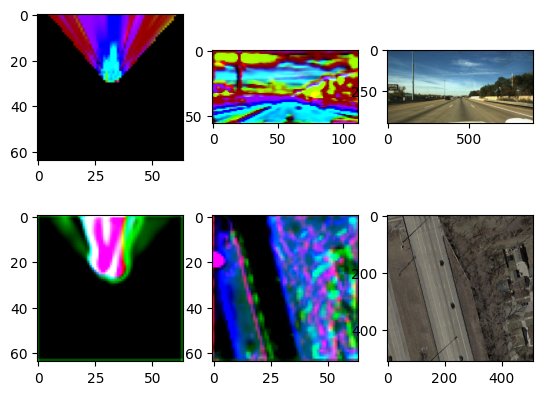

In [51]:
from matplotlib import pyplot as plt 

with torch.no_grad():
    grd_imgs_cat = torch.cat(grd_imgs, dim=0)
    
    grd_out_8 = image_enc(grd_imgs_cat)
    sat_out_8 = sat_enc(sat_img)
    volume = lifting_module(grd_out_8)
    sat_out_8_no_rot = bev_enc(volume)

idc = 3*15
img1 = volume[0,idc:idc+3, :, :, -1].permute([1,2,0]).cpu()
img2 = grd_out_8[0,idc:idc+3, :, :].permute([1,2,0]).cpu()
img3 = sat_out_8[0,idc:idc+3, :, :].permute([1,2,0]).cpu()
img4 = sat_out_8_no_rot[0,idc:idc+3, :, :].permute([1,2,0]).cpu()
img5 = sat_img[0,:, :, :].permute([1,2,0]).cpu()
img6 = grd_imgs[0][0,:, :, :].permute([1,2,0]).cpu()

plt.subplot(2,3,1)
plt.imshow(img1)
plt.subplot(2,3,2)
plt.imshow(img2)
plt.subplot(2,3,3)
plt.imshow(img6)


plt.subplot(2,3,4)
plt.imshow(img4)

plt.subplot(2,3,5)
plt.imshow(img3)
plt.subplot(2,3,6)
plt.imshow(img5)

In [9]:

import numpy as np 
from Ford_dataset import get_xy_map
img_idx = 200
sat_img, grd_imgs, gt_shift_u, gt_shift_v, theta, grd_names, sat_img_no_rot, mask_dt_xy, dt_xy = train_set[img_idx]
sat_img = sat_img.to(config.device)[None, ...]; grd_imgs = tuple([img.to(config.device)[None, ...] for img in grd_imgs])
mask_dt_xy = mask_dt_xy.to(config.device)[None, ...]; dt_xy = dt_xy.to(config.device)[None, ...]

'''
x positive down 
y positive left 
th positive clock wise 
'''
meters_per_pixel = 0.22; sidelength_orig = 512
range_lat = 20; range_lot = 20; rotation_range = 20
dx = (gt_shift_v * range_lat) / (meters_per_pixel * sidelength_orig) #range [-0.5, 0.5] -0.5 bottom part of map +0.5 top part of the satelite map
dy = (gt_shift_u * range_lot) / (meters_per_pixel * sidelength_orig) #range [-0.5, 0.5] -0.5 left part of map +0.5 right part of the satelite map
dth = theta * rotation_range * torch.pi/ 180 # in rads, range[-20,20] degrees 

print(f' dx = {dx:.3f}, dy = {dy:.3f}, dth = {dth:.3f}')
print(f' dx_meters = {gt_shift_v * range_lat:.3f}, dy_meters = {gt_shift_u * range_lot:.3f}, dth_degrees = {theta * rotation_range:.3f}')


with torch.no_grad():
    model.eval()
    out = model(sat_img, grd_imgs)
    # ce =  F.cross_entropy(out[:,:2, :, :], mask_dt_xy)  
    # rmse = torch.mean( ( (dt_xy - F.tanh(out[:,2:, :, :])) **2 ) * mask_dt_xy.unsqueeze(1).float()) ** 0.5
    # loss = ce + 5 * rmse
    # print(loss, ce, rmse)
mask_dt_xy_pred = torch.argmax(out[0, :2, :, :], dim=0)
dt_xy_pred = out[0, 2:, :, :]

'''
xy_nrt = xy with no rotation no translation,where the pixels would be in the original satelite image without the gps error compered to the satelite image with the gps error 
xy_nrt = A @ xy
dt_xy = (xy_nrt - xy)
xy_nrt = xy + dt_xy

A = xy_nrt @ sudo_inverse(xy)

A = xy_nrt_filtered @ sudo_inverse(xy_filtered)
we want to use the mask_dt_xy to use the filtered pixels 

A = [
            [ torch.cos(dth), torch.sin(dth), dx],
            [-torch.sin(dth), torch.cos(dth), dy],
            [0              , 0             , 1]
    ]
'''


idxs = mask_dt_xy_pred.view(-1).type(torch.bool)# from int64 to bool 
dt_xy_filtered = dt_xy_pred.view(2, -1)[:, idxs]

side_length = 64
xy = get_xy_map(side_length).to(config.device)
xy_filtered  = xy.view(2, -1)[:, idxs]
xy_nrt_filtered = xy_filtered + dt_xy_filtered

xy_filtered = torch.concat((xy_filtered, torch.ones_like(xy_filtered[0:1, :])))
xy_nrt_filtered = torch.concat((xy_nrt_filtered, torch.ones_like(xy_nrt_filtered[0:1, :])))


# A = torch.tensor([
#             [torch.cos(dth), torch.sin(dth), dx],
#             [-torch.sin(dth), torch.cos(dth), dy],
#             [0,0,1]
#         ]).to(device)


A_pred =  xy_nrt_filtered  @ torch.linalg.pinv(xy_filtered)
dth_pred = torch.arctan( A_pred[0,1]/ A_pred[0,0])
dx_pred = A_pred[0,2]
dy_pred = A_pred[1,2]

print(f'dx_pred = {dx_pred :.3f} dy_pred = {dy_pred :.3f} dth_pred = {dth_pred :.3f}')
print(f' dx_meters_pred = {dx_pred * (meters_per_pixel * sidelength_orig) :.3f}, dy_meters_pred = {dy_pred * (meters_per_pixel * sidelength_orig) :.3f}, dth_degrees_pred = {dth_pred  * 180 / torch.pi :.3f}')


'cuda'

In [4]:
# resnet = torchvision.models.resnet50(pretrained=True)
# resnet# list(resnet.children())[-3]